In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, RNN, SimpleRNN, GRU
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

tf.get_logger().setLevel('INFO')

/home/bendico765/PycharmProjects/HLT-project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-30 19:14:05.271246: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 19:14:05.309583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 19:14:05.311115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 19:14:06.199709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("subtaskA_train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [4]:
df = df[:20]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              20 non-null     int64 
 1   comment_text    20 non-null     object
 2   conspiratorial  20 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 608.0+ bytes


## Pre processing

<Axes: >

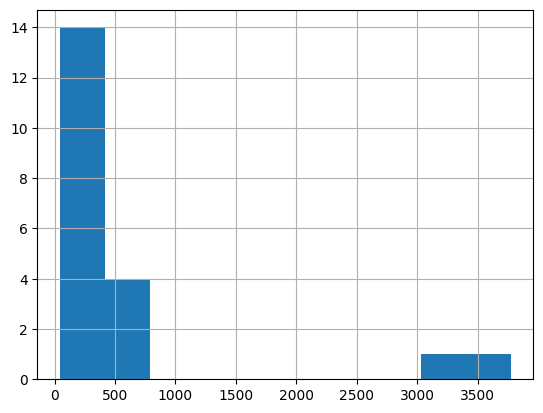

In [6]:
df["comment_text"].map(len).hist()

In [7]:
df = df.drop(df[df["comment_text"].map(len) > 1000].index)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 0 to 18
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              18 non-null     int64 
 1   comment_text    18 non-null     object
 2   conspiratorial  18 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 576.0+ bytes


## Costruzione di train e test set

In [9]:
X = df["comment_text"]
y = df["conspiratorial"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = 10)

In [11]:
tfhub_handle_encoder = "https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang/1"
tfhub_handle_preprocess = "https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang_preprocess/1"

In [16]:
def build_classifier_model():
    # defining inputs
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    # defining preprocessing
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    
    # defining encoder
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    # defining outputs
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    
    # Reshape net to add a time step dimension
    net = tf.expand_dims(net, axis=1)
    
    net = GRU(1)(net)
    #net = tf.keras.layers.LSTM(1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

    return tf.keras.Model(text_input, net)


In [17]:
classifier_model = build_classifier_model()
classifier_model.layers[2].trainable = False

2023-05-30 19:14:47.265704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-30 19:14:47.266402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-30 19:14:47.266538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-30 19:14:47.266965: I tensorflow/core/

2023-05-30 19:14:48.340910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-05-30 19:14:48.361093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-05-30 19:14:52.752205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-05-30 1

In [18]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [19]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [21]:
optimizer = Adam(learning_rate=1e-04, epsilon=1e-08,clipnorm=1.0)

classifier_model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy', 
    metrics = 'accuracy'
)

In [22]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(
    x = X_train,
    y = y_train, 
    epochs=5, 
    validation_split = 0.25, 
    batch_size = 64, 
    callbacks= [ 
        EarlyStopping( monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)
    ]
)


Training model with https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang/1
Epoch 1/5


2023-05-30 19:15:05.016935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 19:15:05.018028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 19:15:05.019185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-05-30 19:15:09.260974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]
2023-05-30 19:15:09.261097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4}}]]
2023-05-30 19:15:09.261171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) 

2023-05-30 19:15:09.733353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]
2023-05-30 19:15:09.733508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4}}]]
2023-05-30 19:15:09.733602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) 

2023-05-30 19:15:10.445572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 19:15:10.447324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 19:15:10.449076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s - loss: 9.9820 - accuracy: 0.2222

2023-05-30 19:15:15.000196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 19:15:15.001088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 19:15:15.002199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 13s 13s/step - loss: 9.9820 - accuracy: 0.2222 - val_loss: 2.1980 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 10.8087 - accuracy: 0.2222 - val_loss: 2.1878 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 10.8691 - accuracy: 0.2222 - val_loss: 2.1784 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 8.8262 - accuracy: 0.2222 - val_loss: 2.1691 - val_accuracy: 0.5000
